# **Module 4: Diagnostic Systems**
## DAT410

### Group 29 
### David Laessker, 980511-5012, laessker@chalmers.se

### Oskar Palmgren, 010529-4714, oskarpal@chalmers.se



We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions.

___


## 1) Article summary and take-aways

The first paper by Wolberg et al. (1994) focuses on development of an interactive computer system that diagnoses breast cancer from FNA slides (fine needle aspirate). By utilising image analysis and machine learning, their system demonstrated high accuracy, which highlighted the potential of combining ML with digital image to enhance accuracy of breast FNAs diagnoses. We thought it was interesting that computer-assisted image analysis was superior to eyepiece measurements with respect to accuracy and reproducability of the results achieved in the breast cancer study.

*The Mythos of Model Interpretability* (2018) discusses the concept of interpretability in machine learning models and its complexity. Transparency in the model decisions and post-hoc interpretations of model outputs are suggested as the main approaches. Models should either be understandable by design or provided with clear explanations of the results in order to achieve trust and fairness. In particular we found the discussion on the tradoffs between linear models and neural networks was interesting and relevant to the work we do, as choosing a model that fits the data is very important.

Our main takeaways from both research papers are the potential and challenges of applying machine learning to areas such as medical diagnostics. Significantly improving the accuracy of a diagnosis with ML is promising, however, we need to ensure that the models used are transparent and easily interpretable for this kind of complicated decision making. There are many factors that come into play when choosing a model that fits the data, and we should be aware of the tradoffs in different aspects when approaching these desicions.


___
## 2) Implementation

### 2.1) Rule-based classifier

For the rule-based classifier, we try two different approaches: 

*(a)*. Based on the supplied data, assuming that we know which cells are malignant/benign from the label column and using the respective data to determine what is abnormal.

*(b)*. Based on the supplied data, but we dont know the labels of each cell. We use the data to calculate an averages and standard deviations to define ourselves what is abnormal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [2]:
# Load dataset as a df
data = pd.read_pickle('wdbc.pkl')

# Show the first few rows
data.head()

,id,malignant,radius_0,texture_0,perimeter_0,area_0,smoothness_0,compactness_0,concavity_0,concave points_0,...,radius_2,texture_2,perimeter_2,area_2,smoothness_2,compactness_2,concavity_2,concave points_2,symmetry_2,fractal dimension_2
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Rule approach a)

For our first approach we create a class called Rule_Classifier. This class attempts to find a few features that have big differences in the malignant an non malignant data. A big difference is defined as the average of the respective means have a difference that is larger than their respective standard deviations added. We then use only these features to classify the diagnosis. If an image has more features that are closer to the malignant means than the non-maligant means it is classified as maligant, and if not, then it is classified as non-maligant. On this approach we are using all of the data as a point for training, as we are using no tuning or cross validation in this approach. It is simply basically mathematical. So if a new image is to be classified, it is only using these big difference points and is trained on all of the previous data. With this approach we achieve an accuracy of 0.907. We decided to remove the unimportant features, as these were difficult to make rules for, and we decided to focus on maing rules for the features who had big differences in mean values, as these give us a likely better prediction based of simple rules. 

In [3]:
class Rule_Classifier:
    def __init__(self, dataframe):
        self.data = dataframe.copy()
        self.big_differences = {}
        self.non_maligant = self.data[self.data['malignant'] == 0].drop('malignant', axis=1)
        self.maligant = self.data[self.data['malignant'] == 1].drop('malignant', axis=1)
        for column in self.data.drop('malignant', axis=1).columns:
            mal_mean = self.maligant[column].mean()
            non_mean = self.non_maligant[column].mean()
            mal_std = self.maligant[column].std()
            non_std = self.non_maligant[column].std()
            if abs(mal_mean - non_mean) > (mal_std + non_std):
                self.big_differences[column] = (non_mean, mal_mean)

    def predict(self, data):
        data['manual_classification'] = 0
        for index, row in data.iterrows():
            non_count = 0
            mal_count = 0
            for column in self.big_differences:
                if abs(row[column] - self.big_differences[column][0]) < abs(row[column] - self.big_differences[column][1]):
                    non_count += 1
                else:
                    mal_count += 1
            if non_count > mal_count: # Tweakable parameter ;)
                data.at[index, 'manual_classification'] = 0
            else:
                data.at[index, 'manual_classification'] = 1
        return data['manual_classification']
    
    def score(self, data):
        correct = 0
        for index, row in data.iterrows():
            if row['manual_classification'] == row['malignant']:
                correct += 1
        accuracy = correct / len(data)
        return accuracy

In [4]:
RB_data = data.copy()

# Create the rule based classifier
rule_classifier = Rule_Classifier(RB_data)

# Predict the class of the data
RB_data['manual_classification'] = rule_classifier.predict(RB_data)

# Calculate the accuracy of the classifier
accuracy = rule_classifier.score(RB_data)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.907


### 2.1 b)

A different approach where we do not know the actual labels, only use the features to predict. We calculate the average $\mu$ and standard deviation $\sigma$, and define abnormal as $\mu \pm k\sigma$. We set $k=2$, which statistically encompasses about $95 \%$ of the data and results in the data in the $2.5$-th and $97.5$-th percentiles being considered abnormal. Here we assume that the given data is normally distributed, which is not really the case for some features when looking at the histogram plots below. 

In [5]:
benign = data[data['malignant'] == 0]
malignant = data[data['malignant'] == 1]

features = ['radius_0', 'perimeter_0', 'area_0', 'concavity_0', 'concave points_0', 'compactness_0', 'texture_0', 'smoothness_0', 'symmetry_0']

data_stats = data[features].agg(['mean', 'std'])

data_stats

,radius_0,perimeter_0,area_0,concavity_0,concave points_0,compactness_0,texture_0,smoothness_0,symmetry_0
mean,14.127292,91.969033,654.889104,0.088799,0.048919,0.104341,19.289649,0.096360,0.181162
std,3.524049,24.298981,351.914129,0.079720,0.038803,0.052813,4.301036,0.014064,0.027414


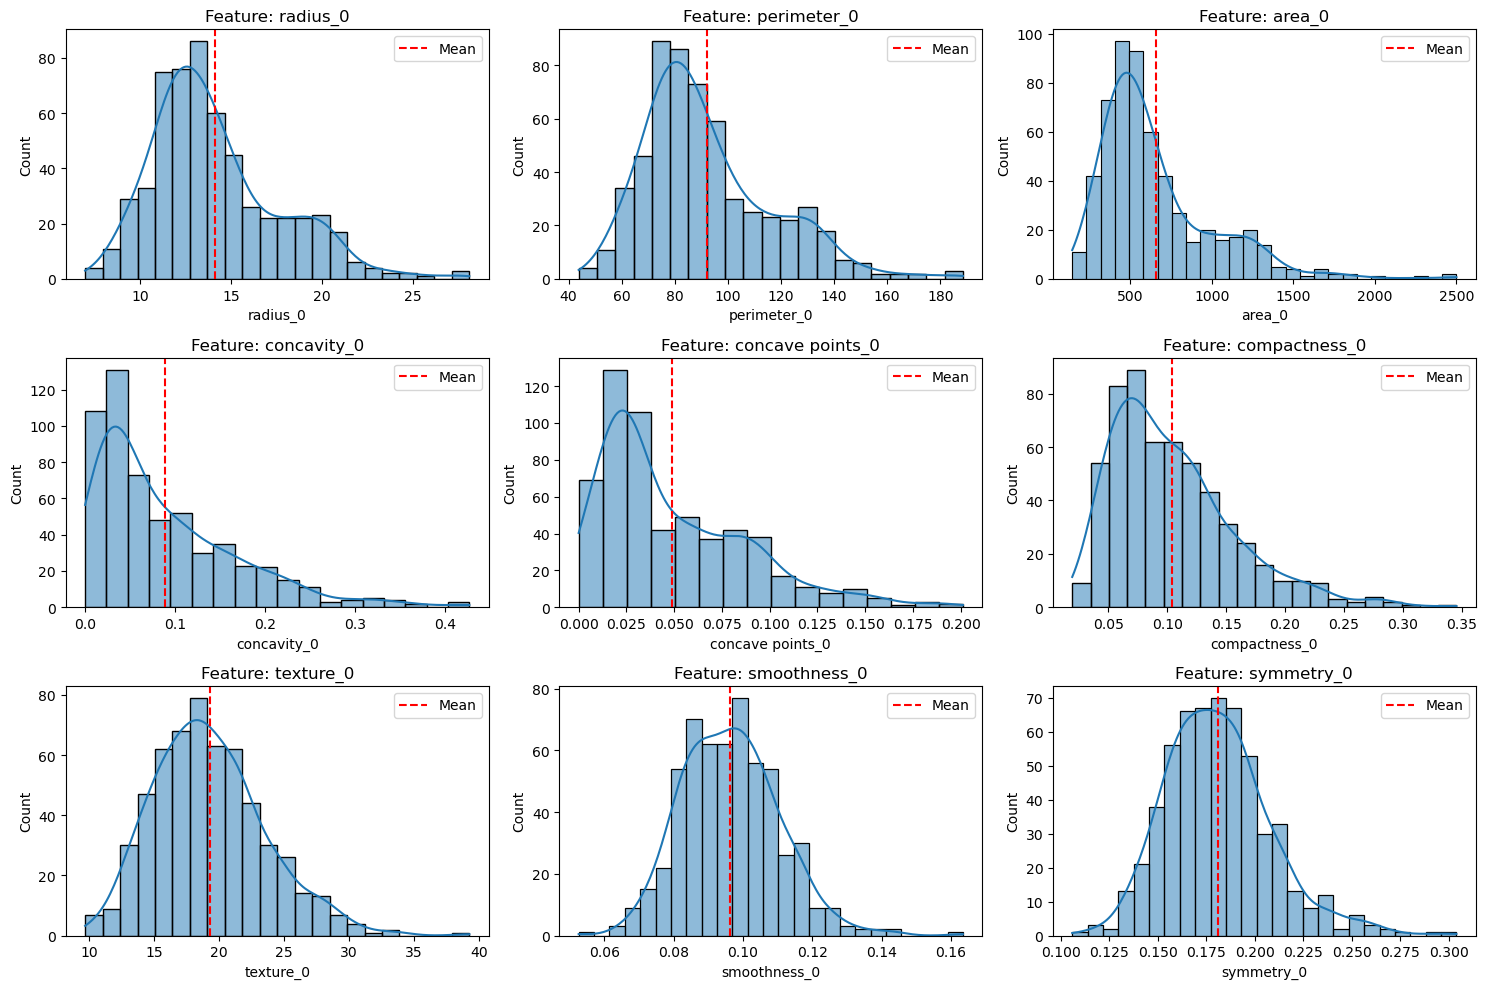

In [6]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.axvline(data_stats[feature].loc['mean'], color='r', linestyle='dashed', label='Mean')
    plt.legend(loc='upper right')
    plt.title(f'Feature: {feature}')


plt.tight_layout()
plt.show()



In [7]:
def RB_classifier2(row, stats, features):
    '''
    Rule based classifier, goes through all the rows of data feature by feature. 
    If the value is larger than the mean + 2 std or smaller than mean - 2std, 
    then the row is classified as malignant. Otherwise benign
    '''

    for feature in features:
        
        mean = stats[feature]['mean']
        std = stats[feature]['std']
        
        if row[feature] > mean + 2*std or row[feature] < mean - 2*std: 
            return 1
    
    return 0



prediction =  data.copy().apply(RB_classifier2, axis=1, args=(data_stats, features,))


accuracy_score(data['malignant'], prediction)


0.6766256590509666

We get an accuracy of 67.7%, which is worse than the previous classifier. Some possible factors in order to improve the score would be to take into account that the data is not normally distributed, and shift the thresholds for what is considered abnormal. For example, for concacivity_0, instead of defining $\mu \pm 2\sigma$ as normal, we could have $\mu - 1\sigma$ and $\mu + 3\sigma$.

### 2.2) Random Forest Classifier

Here we are using the random forest classifier to classify the data instead. We achieve an accuracy of 0.965

In [8]:
data_features = data.drop(columns=['id', 'malignant'])
data_labels = data['malignant']

X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2, random_state=0)

RF_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9649122807017544


### 2.3) Own Classifier

For our own classifier we decided to implement feature boosting. We create a class for this called Boosting_Classifier, after testing and plotting we got the best performance at about 500 estimators and upwards, using a max_depth of 1. We achieve a significant improvement on the random forest classifier.

In [9]:
# -------------------- Feature boosting --------------------
# We crate a classifier class using the GradientBoostingClassifier from sklearn
# We use the init, predict and score methods to create a classifier class

from sklearn.ensemble import GradientBoostingClassifier

class Boosting_Classifier:
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.drop(columns=['id', 'malignant'])
        self.labels = self.data['malignant']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.labels, test_size=0.2, random_state=0)
        self.clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=1, random_state=0)
        self.clf.fit(self.X_train, self.y_train)
        self.y_pred = self.clf.predict(self.X_test)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        
    def predict(self, data):
        return self.clf.predict(data)
    
    def score(self, data):
        return self.accuracy

GB_data = data.copy()
# Create the boosting classifier
boosting_classifier = Boosting_Classifier(GB_data)

# Predict the class of the data
GB_data['manual_classification'] = boosting_classifier.predict(GB_data.drop(columns=['id', 'malignant']))

# Calculate the accuracy of the classifier
accuracy = boosting_classifier.score(GB_data)
print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.98246


### Our model discussion

Our model, although not quite as interpretable as a basic rule classifier and perhaps less interprable than a random forest, is still more interpretable than let’s say a deep neural network. Gradient boosting has a learning process which is a bit more complicated than a simple decision tree, but it is still understandable, as the result still is a decision tree. We are quite happy about our performance, as it clearly outperformed the random forest classifier, which is a common model used for this type of problem. We can also see the feature imporance which can be cruical, but more about this later in the discussion.
___

### Model testing

We also tested using a decision tree classifier but decided against it since gradient boosting gave us better performance

In [10]:
# Use decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
DTC_clf = DecisionTreeClassifier(random_state=0, max_depth=3)

# Train the classifier
DTC_clf.fit(X_train, y_train)

# Make predictions
y_pred = DTC_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.965


We did tune the hyperparameters of the Gradient boosting classfier using a randomized search, to see which values for the parameters resulted in the highest accuracy. The results showed that n_estimators of over 500, learning rate of below 0.1 and max_depth of 1 had the best performance. We decided against using other hyperparameters in the final model since it increased the running time yet had about the same accuracy score.

In [35]:
from sklearn.model_selection import RandomizedSearchCV


parameter_space = {
    'n_estimators': [300, 400, 500, 600],
    'learning_rate': [x for x in np.arange(0.01, 0.11, 0.01)],
    'max_depth': [1, 2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 10],
    'max_leaf_nodes': [10, 20, 30, 40, 50],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
    }


GBC = GradientBoostingClassifier(random_state=1)


#Hyperparameter tuning
test_search = RandomizedSearchCV(GBC, parameter_space, n_jobs=-1, cv=3)
test_search.fit(X_train, y_train)

print('Best parameters:', test_search.best_params_)
print('Best score:', test_search.best_score_)

Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_leaf_nodes': 20, 'max_depth': 1, 'learning_rate': 0.04}
Best score: 0.9648832345765075


In [36]:
#Evaluating the validation dataset on the classifier with "optimal" hyperparameters

GBC_test = GradientBoostingClassifier(n_estimators=500, subsample=0.7, min_samples_split=6, min_samples_leaf=6, max_leaf_nodes=20, max_depth=1, learning_rate= 0.04, random_state=1)

GBC_test.fit(X_train, y_train)

y_pred = GBC_test.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)



0.9824561403508771


Furthermore, we analyzed which features in the dataset that were most important for the prediction in the Gradient Boosting classifier. We noticed when working with our model, that different random states would produce different feature importances. This is likely due to the fact that the dataset contains features that are correlated with each other, and either feature can serve a similar purpose in making predictions. In order to generate a better feature importance highlight (interpretability), we decided to train ten models with different random states, and calculate the average feature importance.  

We thought it was interesting that the features ending in "_2" seemed to be the defining features in the model predictions. It is reasonable since those values represent the worst cases which certainly are abnormal. Another interesting point is that concavity, area and texture matter the most when classifying the cells.

In [38]:
results = []

for i in range(11):
    
    GBC_test = GradientBoostingClassifier(n_estimators=500, subsample=0.6, min_samples_split=6, min_samples_leaf=2, max_leaf_nodes=50, max_depth=1, learning_rate= 0.18, random_state=i)
    GBC_test.fit(X_train, y_train)

    y_pred = GBC_test.predict(X_test)

    # access feature names and importance scores
    feature_names = data_features.columns
    importances = GBC_test.feature_importances_.tolist()

    # associate importance scores with feature names and sort in descending order
    result = {feature_names[i]: importances[i] for i in range(len(feature_names))}
    results.append(result)


# Calculate the averages
averages = {key: 0 for key in results[0]}

for d in results:
    for key in d:
        averages[key] += d[key]

for key in averages:
    averages[key] /= len(results)


In [39]:
result_sorted = sorted(averages.items(), key=lambda x:x[1], reverse=True)

# Show the 10 most important features
for res in result_sorted[:10]:
    print(res)

('concave points_2', 0.28388098972229997)
('perimeter_2', 0.2701529922264321)
('concave points_0', 0.1795548511334485)
('area_2', 0.0830765479090028)
('radius_2', 0.047301202050421966)
('area_1', 0.026054195531634492)
('texture_2', 0.023142806355213805)
('symmetry_2', 0.01282223089615041)
('texture_0', 0.011101639368579231)
('smoothness_2', 0.010753642157757618)


___

### Comparison of the three classifiers.

The first model has the highest interpretability, it uses pretty simple mathematical rules to classify the diagnoses, and these can be changed rather simply. However, the performance is very poor compared to the other models. As mentioned before, although the learning process of the Gradiant boosting method can be more complicated to understand, the interpretability of the end result is the same, a decision tree. And from our perspective the interpretability of these models are still higher than a deep neural network.

___
## 3) Discussion

Interpretability may be defined as how transparent and easy the model is to understand. Higher clarity in understanding of the results will result in higher interpretability. The ability to understand and explain how the models make their predictions is crucial since medical institutions are more likely to trust and adopt models that provide transparent reasoning. It offers insights into the process of diagnosis and understandable models make it easier to identify and correct potential errors. However, highly interpretable models may not always achieve the same level of accuracy as more complex models, which can lead to a trade off between interpretability and model performance. When over-simplifiying in order to enhance interpretability, we may overlook complex interactions between features that are relevant for accurate predictions.


However interpretability is definitely not something you want to be completely focused on, as incorrect medical diagnoses can ruin lives. Simply focusing on making as effective of a model as possible, may have negative consequences in the long run. For example, if we were to use a deep neural network for classification instead of the models we used, we would have no insight into what parameters (image features) are of importance. This is important to consider, because highlighting these may give insight to the doctors, and the people who collect the data and work with patients, what things are most important. We can see in our feature importance how important some image features are, and how unimportant others were. And this is crucial for future improvements of the data, model and all of the work around it for the future.

Ultimately, the goal in healthcare applications is to have a balance between good accuracy and a level of interpretability that supports the tough clinical decision-making, ensuring that the model's predictions are both accurate and understandable to physicians and patients who rely on them. 